# Two-Way Mixed Anova

## Dataset and Problem

The dataset contains information about cholesterol levels at three different time points (Before, After4weeks, and After8weeks) for participants who use two different margarine brands (A and B).

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt
import numpy as np
import statistics
from scipy.stats import shapiro
from scipy.stats import levene
import pingouin as pg

from IPython.display import display, HTML
pd.options.display.float_format = '{:.3f}'.format

df = pd.read_csv("Cholesterol_R2.csv")
df.head()

,ID,Before,After4weeks,After8weeks,Margarine
0,1,6.420,5.830,5.750,B
1,2,6.760,6.200,6.130,B
2,3,6.560,5.830,5.710,B
3,4,4.800,4.270,4.150,A
4,5,8.430,7.710,7.670,B


## Formulation of Hypotheses
\$ H_0 \$: There is no significant difference in the cholesterol levels between the two brands of margarine over the three time points. \
\$ H_A \$: There is a significant difference in the cholesterol levels between the two brands of margarine over the three time points.

## Assumptions

### Assumption 1: You have a continuous dependent variable.
**Remark:** The dependent variable *cholesterol level* is measured at the continuous level

### Assumption 2: You have one between-subjects factor (i.e., independent variable) that is categorical with two or more categories.
**Remark:** The between-subjects factor is the brand of margarine and has 2 categories.


### Assumption 3: You have one within-subjects factor (i.e., independent variable) that is categorical with two or more categories.
**Remark:** The within-subjects factor is time and has 3 categorical levels (before, after 4 weeks, after 8 weeks).

### Assumption 4: There should be no significant outliers in any cell of the design.

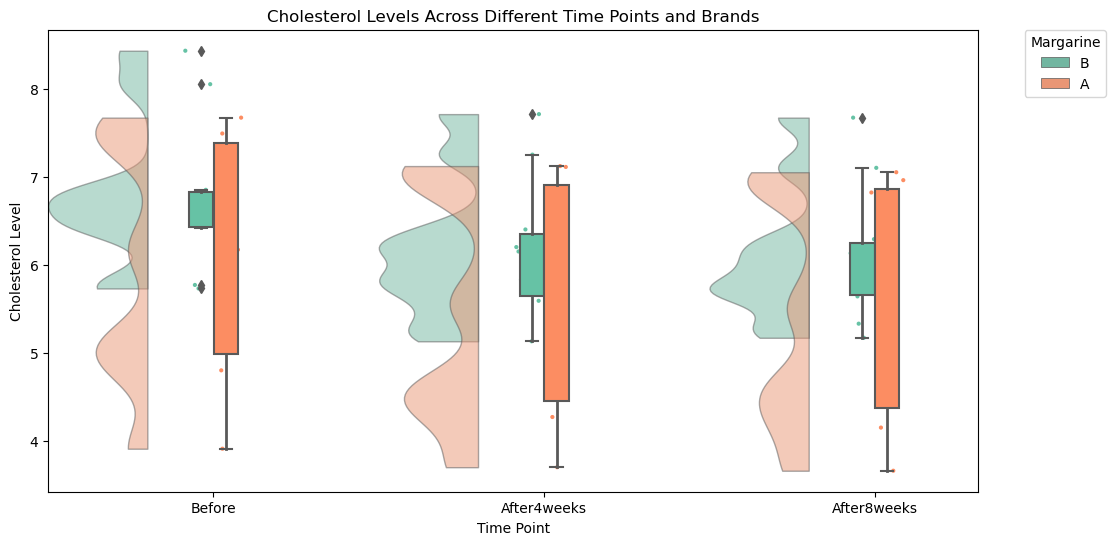

In [29]:
df_melted = pd.melt(
    df,
    id_vars=["ID", "Margarine"],
    value_vars=["Before", "After4weeks", "After8weeks"],
    var_name="Time",
    value_name="Cholesterol_Level"
)

plt.figure(figsize=(12, 6))
pt.RainCloud(
    data=df_melted,
    x="Time",
    y="Cholesterol_Level",
    hue="Margarine",
    width_viol=0.6,
    alpha=0.5,
    palette="Set2",
    dodge=True
)
plt.title("Cholesterol Levels Across Different Time Points and Brands")
plt.xlabel("Time Point")
plt.ylabel("Cholesterol Level")
plt.show()

As observed from the boxplots, there are several outliers in the data groups for Brand B. We will now proceed to removing these as to not skew the results of the ANOVA. In this case, there are four outliers.

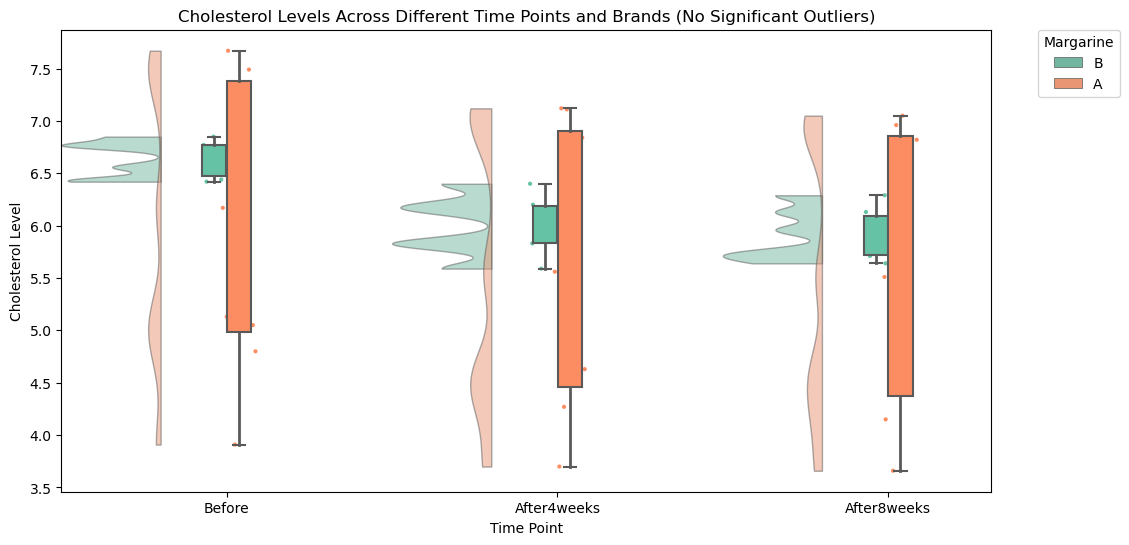

In [6]:
df = df.drop([4,6,8,17])

df_melted = pd.melt(
    df,
    id_vars=["ID", "Margarine"],
    value_vars=["Before", "After4weeks", "After8weeks"],
    var_name="Time",
    value_name="Cholesterol_Level"
)

plt.figure(figsize=(12, 6))
pt.RainCloud(
    data=df_melted,
    x="Time",
    y="Cholesterol_Level",
    hue="Margarine",
    width_viol=0.6,
    alpha=0.5,
    palette="Set2",
    dodge=True
)
plt.title("Cholesterol Levels Across Different Time Points and Brands (No Significant Outliers)")
plt.xlabel("Time Point")
plt.ylabel("Cholesterol Level")
plt.show()

### Assumption 5: The dependent variable should be approximately normally distributed for each cell of the design

In [7]:

df_grouped = df.groupby('Margarine')[['Before', 'After4weeks', 'After8weeks']]

desc = df_grouped.agg({
    'Before': ['count', 'mean', 'std', 'skew', lambda x: x.kurt()],
    'After4weeks': ['count', 'mean', 'std', 'skew', lambda x: x.kurt()],
    'After8weeks': ['count', 'mean', 'std',  'skew', lambda x: x.kurt()]
})

desc.rename(columns={'count': 'Valid', 'mean': 'Mean', 'std': 'SD', 
                     'skew': 'Skew','<lambda_0>': 'Kurt'}, inplace=True)
results = {}
for name, group in df_grouped:
    for column in group.columns:
        stat, p = shapiro(group[column])
        results[(name,column)] =(stat,p)

shapiro_df = pd.DataFrame(results).rename(index={0:'Shapiro', 1:'p-value'})

display(HTML("""<h4>Descriptive Statistics</h4>"""), desc)
display(HTML("""<h4>Shapiro-Wilk's Test for Normality</h4>"""), shapiro_df)


Before                           After4weeks                     \
           Valid  Mean    SD   Skew   Kurt       Valid  Mean    SD   Skew   
Margarine                                                                   
A              8 5.945 1.428  0.024 -1.744           8 5.469 1.388  0.200   
B              6 6.633 0.184 -0.123 -2.428           6 6.000 0.299 -0.038   

                 After8weeks                           
            Kurt       Valid  Mean    SD  Skew   Kurt  
Margarine                                              
A         -1.998           8 5.409 1.374 0.172 -2.010  
B         -1.234           6 5.913 0.258 0.531 -1.483

A                              B                        
        Before After4weeks After8weeks Before After4weeks After8weeks
Shapiro  0.901       0.871       0.876  0.880       0.951       0.921
p-value  0.292       0.154       0.174  0.270       0.746       0.512

**Remark:** As assessed by Shapiro-Wilk's test for normality, the distribution is normal (p>0.05) for every cell in the design.

### Assumption 6: The variance of your dependent variable should be equal between the groups of the between-subjects factor, referred to as the assumption of homogeneity of variances.

In [8]:

group_A = df[df["Margarine"] == "A"]
group_B = df[df["Margarine"] == "B"]
levene_results= {}
for col in ["Before", "After4weeks", "After8weeks"]:
    stat, p_value = levene(group_A[col], group_B[col])
    levene_results[(col)] =(stat,p)
    
levene_df = pd.DataFrame(levene_results).transpose()

levene_df = pd.DataFrame({
    'F' : levene_df[0],
    'p': levene_df[1],
    'df1': [1,'', ''],  
    'df2': [12, '', '']
})

display(HTML("""<h4>Levene's Test for Homogeneity of Variances</h4>"""), levene_df)


,F,p,df1,df2
Before,15.291,0.512,1,12
After4weeks,10.776,0.512,,
After8weeks,12.570,0.512,,


**Remark:** As assessed by Levene's test, the variance of cholesterol levels at different times between groups A and B is homogeneous (p>0.05).

### Assumption 7: There should be homogeneity of covariances.

In [9]:
box_m_result = pg.box_m(
    data=df,
    dvs=["Before", "After4weeks", "After8weeks"], 
    group="Margarine" 
)

box_m_result

,Chi2,df,pval,equal_cov
box,15.133,6.000,0.019,True


**Remark:** As assessed by Box's M test, the covariances are homogeneous (p>0.05).

### Assumption 8: The variance of the differences between groups should be equal, referred to as the assumption of sphericity.

In [17]:

mauchly_test = pg.sphericity(data=df_melted, dv='Cholesterol_Level', subject='ID', within='Time')

mauchly_df = pd.DataFrame(mauchly_test).transpose()
mauchly_df.columns = ['spher', 'W', 'chi2', 'dof', 'pval']

display(HTML("""<h4>Mauchly’s Test of Sphericity</h4>"""), mauchly_df)


,spher,W,chi2,dof,pval
0,False,0.387,11.407,2,0.003


**Remark:** Since p < 0.05, then the dataset fails Assumption 8. However, we can still proceed with the two-way mixed ANOVA given that a Greenhouse-Geisser correction is applied. The pingouin.mixed_anova() automatically applies this by default.


## Computation

### Two-Way Mixed ANOVA

In [20]:
anova = pg.mixed_anova(dv='Cholesterol_Level', between='Margarine', within='Time', subject='ID', data=df_melted)
anova

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Margarine,3.397,1,12,3.397,0.977,0.342,NaN,0.075,NaN,NaN,NaN,NaN
1,Time,3.168,2,24,1.584,208.539,0.000,0.000,0.946,0.620,False,0.387,0.003
2,Interaction,0.068,2,24,0.034,4.450,0.023,NaN,0.271,NaN,NaN,NaN,NaN


### Post-Hoc Analyses

Since sphericity was violated, we shall proceed to the post-hoc analyses with Bonferroni-adjusted data.

In [27]:
post_hoc_time = pg.pairwise_tests(
    dv='Cholesterol_Level',
    within='Time',
    subject='ID',
    data=df_melted,
    padjust='bonf'
)
post_hoc_time['Effect'] = 'Time'

post_hoc_interaction = pg.pairwise_tests(
    dv='Cholesterol_Level',
    within='Time',
    subject='ID',
    between='Margarine',
    data=df_melted,
    padjust='bonf'
)
post_hoc_interaction['Effect'] = 'Time x Margarine'

combined_post_hoc = pd.concat([post_hoc_time, post_hoc_interaction])
combined_post_hoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges,Effect,Time
0,Time,After4weeks,After8weeks,True,True,4.009,13.000,two-sided,0.001,0.004,bonf,27.936,0.065,Time,NaN
1,Time,After4weeks,Before,True,True,-13.097,13.000,two-sided,0.000,0.000,bonf,1.5e+06,-0.484,Time,NaN
2,Time,After8weeks,Before,True,True,-13.489,13.000,two-sided,0.000,0.000,bonf,2.081e+06,-0.551,Time,NaN
0,Time,After4weeks,After8weeks,True,True,4.009,13.000,two-sided,0.001,0.004,bonf,27.936,0.065,Time x Margarine,-
1,Time,After4weeks,Before,True,True,-13.097,13.000,two-sided,0.000,0.000,bonf,1.5e+06,-0.484,Time x Margarine,-
2,Time,After8weeks,Before,True,True,-13.489,13.000,two-sided,0.000,0.000,bonf,2.081e+06,-0.551,Time x Margarine,-
3,Margarine,A,B,False,True,-1.143,7.561,two-sided,0.288,NaN,NaN,0.681,-0.500,Time x Margarine,-
4,Time * Margarine,A,B,False,True,-1.051,7.854,two-sided,0.325,0.974,bonf,0.64,-0.462,Time x Margarine,After4weeks
5,Time * Margarine,A,B,False,True,-1.015,7.652,two-sided,0.341,1.000,bonf,0.625,-0.445,Time x Margarine,After8weeks
6,Time * Margarine,A,B,False,True,-1.348,7.309,two-sided,0.218,0.653,bonf,0.795,-0.587,Time x Margarine,Before


## Interpretation

The study explored how cholesterol levels were influenced by the margarine brand (a between-subjects factor) and how they changed over three time points: Before, After 4 weeks, and After 8 weeks (a within-subjects factor). Initial boxplots showed that there were significant outliers in Brand B, thus they were removed. The analysis accounted for all necessary assumptions, including but not limited to normality, homogeneity of variances, and no significant outliers. However, the assumption of sphericity for the within-subjects factor was violated, as indicated by the significant p-value of the sphericity test (\$p=0.003\$). Consequently,the Greenhouse-Geisser was applied to adjust the degrees of freedom for the factor of Time, ensuring the validity of the results. Additionally, the data were Bonferroni-adjuste before the post hoc analyses were conducted since sphericity was violated.

The main effect of margarine was not statistically significant (F(1,12)=0.977, p=0.342). This finding suggests that the brand of margarine (A or B) did not lead to any significant differences in cholesterol levels over the duration of the study. The lack of a significant main effect for margarine implies that both brands of margarine performed similarly in their impact on cholesterol levels. The effect size for this factor was also small (η²p=0.075), further confirming the minimal influence of margarine brand on cholesterol levels.

In contrast, the main effect of time was highly significant (F(2,24)=208.539, p<0.001) and demonstrated a large effect size (η²p=0.946), indicating that cholesterol levels changed significantly over the three time points. Pairwise post hoc comparisons revealed significant reductions in cholesterol levels between all pairs of time points. Specifically, cholesterol levels decreased significantly from Before to After 4 weeks (p_corr<0.001), from Before to After 8 weeks (p_corr<0.001), and from After 4 weeks to After 8 weeks (p_corr=0.004). These findings confirm a consistent and statistically significant reduction in cholesterol levels over the 8 weeks, emphasizing the importance of time as a critical factor in cholesterol reduction.

The interaction between time and margarine brand was also significant (F(2,24)=4.450, p=0.023), suggesting that the effect of time on cholesterol levels varied depending on the type of margarine. However, further post hoc analysis of the interaction effect did not reveal any statistically significant pairwise differences between margarine brands at any of the three time points (p_corr>0.05). This indicates that while the overall interaction effect was significant, the differences between the margarine brands at specific time points were not substantial enough to reach statistical significance after accounting for multiple comparisons. Additionally, the effect size for the interaction (η²p=0.271) was relatively small, indicating that the interaction contributed modestly to the variability in cholesterol levels.

In summary, the results indicate that time played a significant role in reducing cholesterol levels, with levels decreasing consistently across the study period. Both margarine brands were effective in lowering cholesterol levels, but the brand of margarine did not significantly influence the magnitude of the reduction. While the interaction effect suggests that there may be subtle differences in how the margarine brands affect cholesterol levels over time, these differences were not strong enough to be statistically significant in post hoc comparisons. The findings emphasize the role of time in cholesterol management and that both margarine brands can be equally effective in promoting cholesterol reduction. However, further studies with larger sample sizes may be necessary to explore potential nuanced differences between the margarine brands and their interaction with time in greater detail.